# Multinomial distribution - pre-election polling
From Gelman et al:

*For a simple example of a multinomial model, we consider a sample survey question with three possible responses. In late October, 1988, a survey was conducted by CBS News of 1447 adults in the United States to find out their preferences in the upcoming presidential election.*

*Out of 1447 persons, $y_1 = 727$ supported George Bush, $y_2 = 583$ supported Michael Dukakis, and $y_3 = 137$ supported other candidates or expressed no opinion. Assuming no other information on the respondents, the 1447 observations are exchangeable. If we also assume simple random sampling (that is, 1447 names 'drawn out of a hat'), then the data $(y_1,\ y_2,\ y_3)$ follow a multinomial distribution, with parameters $(\theta_1,\ \theta_2,\ \theta_3)$, the proportions of Bush supporters, Dukakis supporters, and those with no opinion in the survey population. An estimand of interest is $\theta_1 - \theta_2$, the population difference in support for the two major candidates.*



In [1]:
data = [727,583,137]

In [2]:
import sys
sys.path.append('../../Utilities')
import pystan
import stan_utility

import arviz as az
import numpy as np
import scipy.stats as stats

import pandas as pd

In this notebook we are using additional package [```mpltern``` ](https://mpltern.readthedocs.io/en/latest/index.html) which will be used for visualising simplexes.

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import mpltern

light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200


func_dict = {
     "median": lambda x: np.percentile(x, 50),
     "5%": lambda x: np.percentile(x, 5),
     "95%": lambda x: np.percentile(x, 95)
 }

## Prior predictive distribution

In [4]:
with open('election_ppc.stan', 'r') as file:
    print(file.read())

data {
  int K; // number of categories
  int N; // total votes
}
generated quantities {
  simplex[K] theta = dirichlet_rng(rep_vector(1, K));
  int y_ppc[K] = multinomial_rng(theta,N);
}



In [5]:
model_ppc = stan_utility.compile_model('election_ppc.stan')

Using cached StanModel


In [6]:
ppc = model_ppc.sampling(data=dict(K = 3,N = np.sum(data)),seed=13052020,algorithm='Fixed_param',chains=1,iter=1000,refresh=1000,warmup=0)

In [7]:
ppc.to_dataframe().iloc[:,3:9].to_numpy()
names = list(ppc.to_dataframe().iloc[:,3:9].columns)
order = [0,3,1,4,2,5]
names = [names[i] for i in order]
y_ppc = ppc.to_dataframe().iloc[:,3:9][names].to_numpy()
titles = [r'$\theta[1]$', 
          '$y_{ppc}[1]$',
          r'$\theta[2]$',
          '$y_{ppc}[2]$',
          r'$\theta[3]$',
          '$y_{ppc}[3]$']


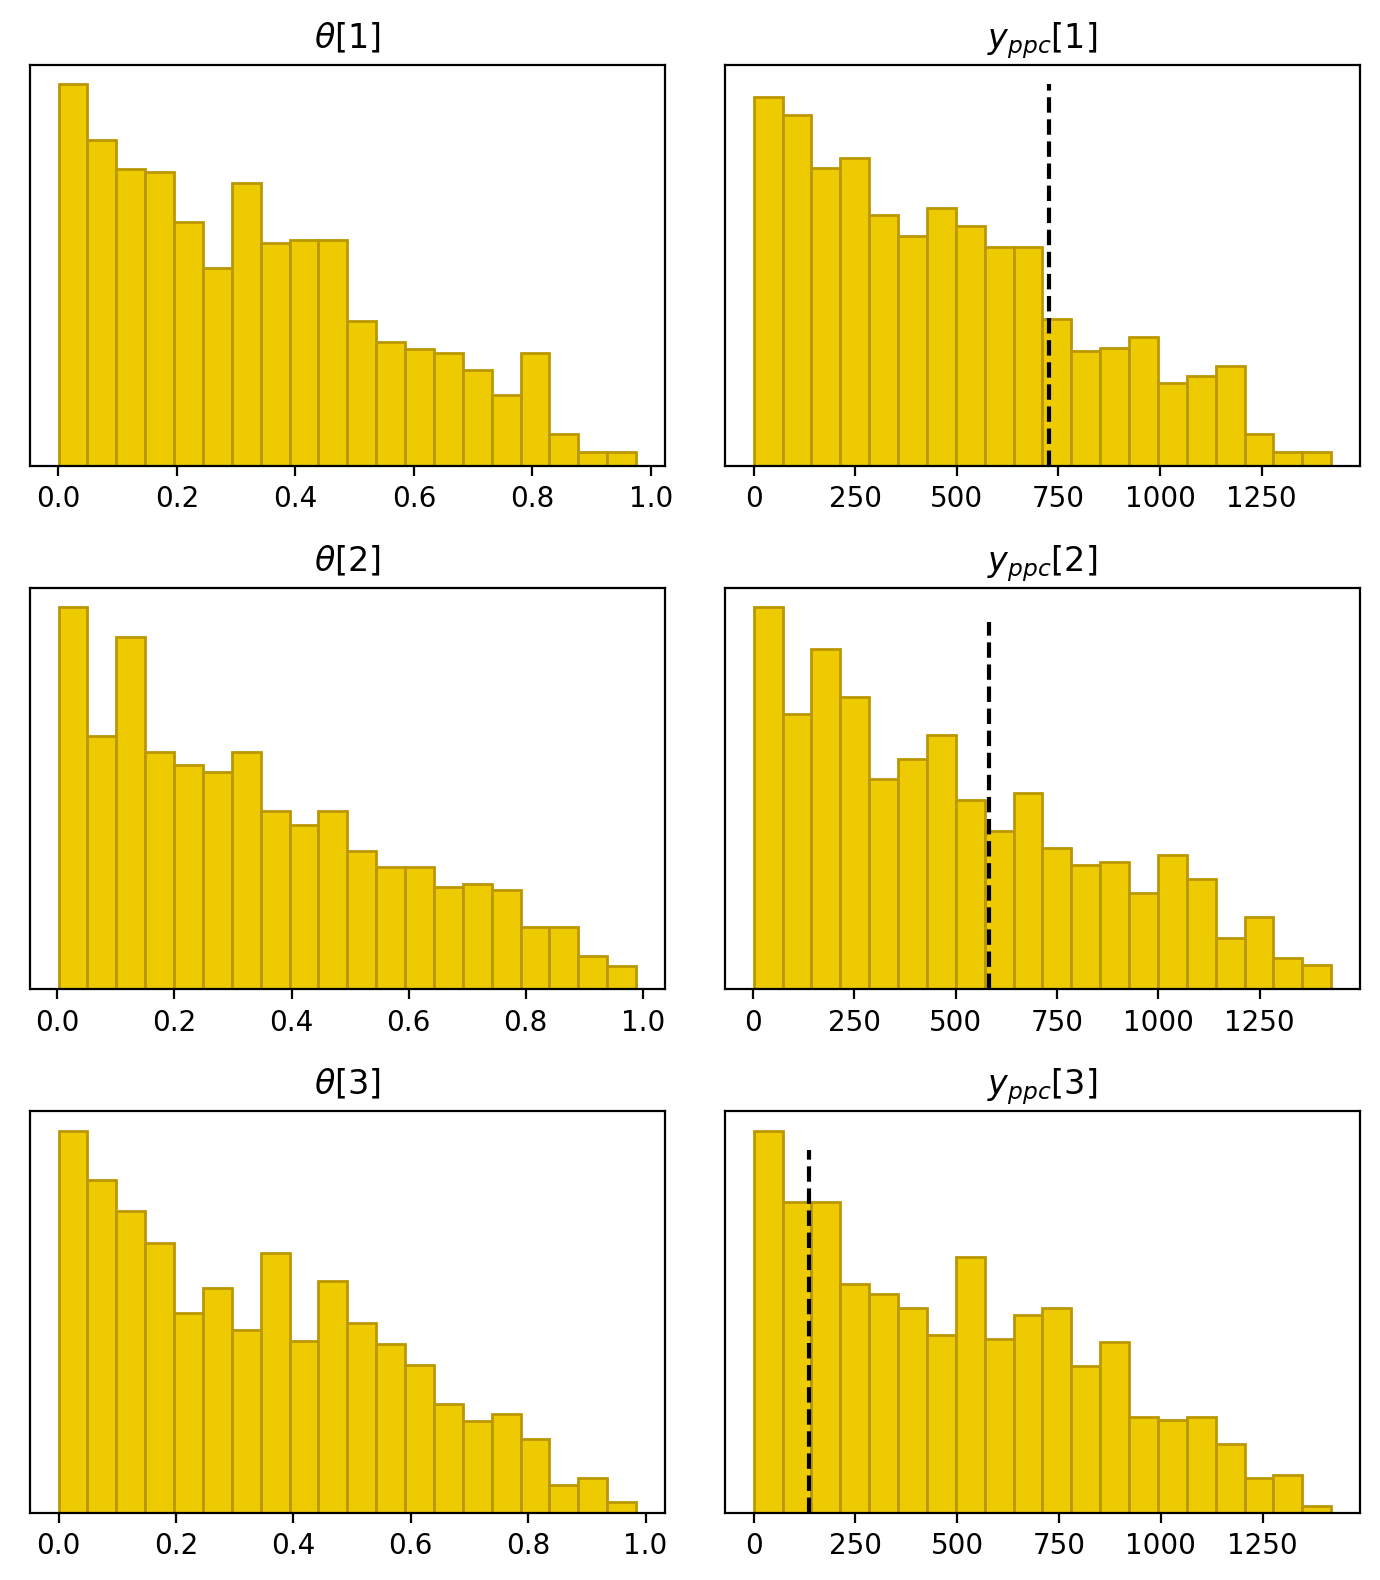

In [8]:
fig, axes = plt.subplots(3, 2, figsize=(7, 8), squeeze=False)
axes_flat=axes.flatten()
tvs=iter(data)
for k in range(len(axes_flat)):
    ax = axes_flat[k]
    ax.hist(y_ppc[:,k],bins=20,color=dark,edgecolor=dark_highlight,density=True)
    ax.set_title(titles[k])
    if (k % 2) == 1:
        tv = next(tvs)
        ax.plot([tv,tv],[0,0.0015],linestyle='--',color='black') 
    ax.set_yticks([])


fig.tight_layout()

plt.show()

### Samples from joint distribution of $\theta$

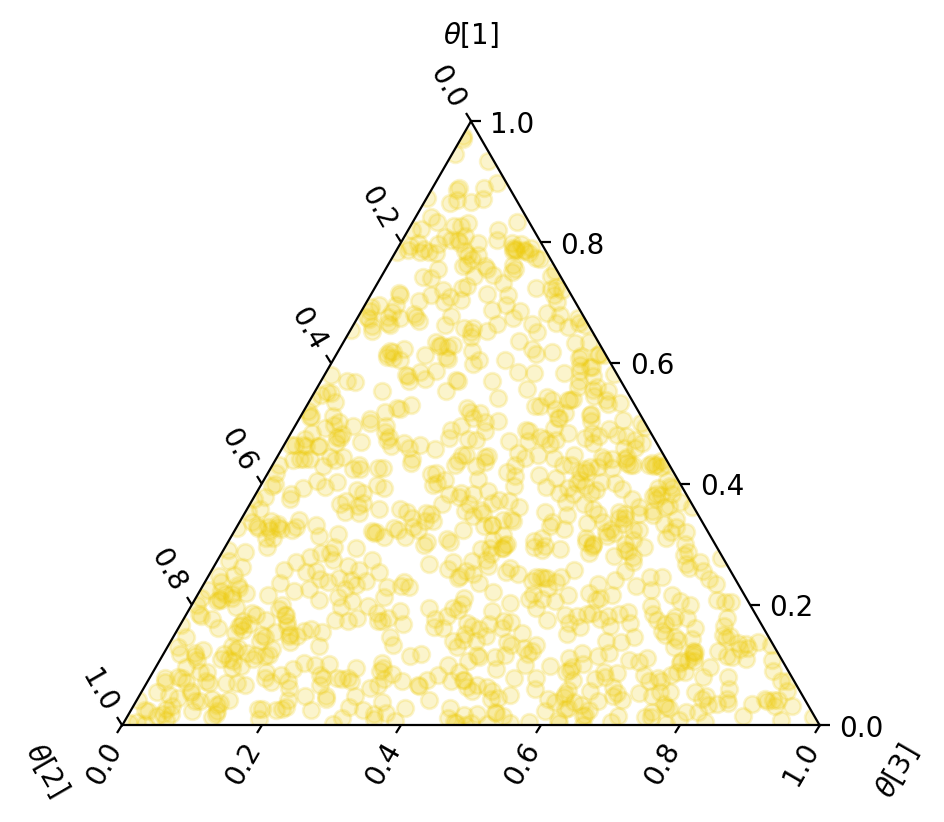

In [9]:
fig, ax_tr = plt.subplots(1, 1, figsize=(7, 4),subplot_kw={'projection':'ternary'})
ax_tr.set_tlabel(r'$\theta[1]$')
ax_tr.set_llabel(r'$\theta[2]$')
ax_tr.set_rlabel(r'$\theta[3]$')
ax_tr.scatter(y_ppc[:,0], y_ppc[:,2], y_ppc[:,4],alpha=0.2,color=dark)
plt.show()

## Posterior analysis and predictions

In [10]:
with open('election_fit_gq.stan', 'r') as file:
    print(file.read())
model_gq = stan_utility.compile_model('election_fit_gq.stan')

data {
  int K; // number of categories
  int y[K]; //result of survey
}

parameters {
  simplex[K] theta;
}

model {
  y ~ multinomial(theta);
}
generated quantities {
  int y_sim[K];
  real advantage = theta[1]-theta[2];
  {
    int n;
    n = sum(y);
    y_sim = multinomial_rng(theta,n);
  }
}

Using cached StanModel


In [11]:
dane = dict(K = 3,y = data)

In [12]:
fit = model_gq.sampling(data=dane, seed=27042020)

In [13]:
az.summary(fit,stat_funcs=func_dict,extend=False,var_names=['theta','y_sim'])

,median,5%,95%
theta[0],0.502,0.481,0.523
theta[1],0.403,0.381,0.424
theta[2],0.095,0.083,0.109
y_sim[0],727.000,683.000,769.000
y_sim[1],583.000,539.000,626.000
y_sim[2],137.000,113.000,164.000


In [14]:
fit_df = fit.to_dataframe()
names=list(fit_df.iloc[:,3:9].columns)
order=[0,3,1,4,2,5]
names=[names[i] for i in order]
y_sim = fit_df.iloc[:,3:9][names].to_numpy()
titles = [r'$\theta[1]$', 
          '$y_{sim}[1]$',
          r'$\theta[2]$', 
          '$y_{sim}[2]$', 
          r'$\theta[3]$', 
          '$y_{sim}[3]$]']

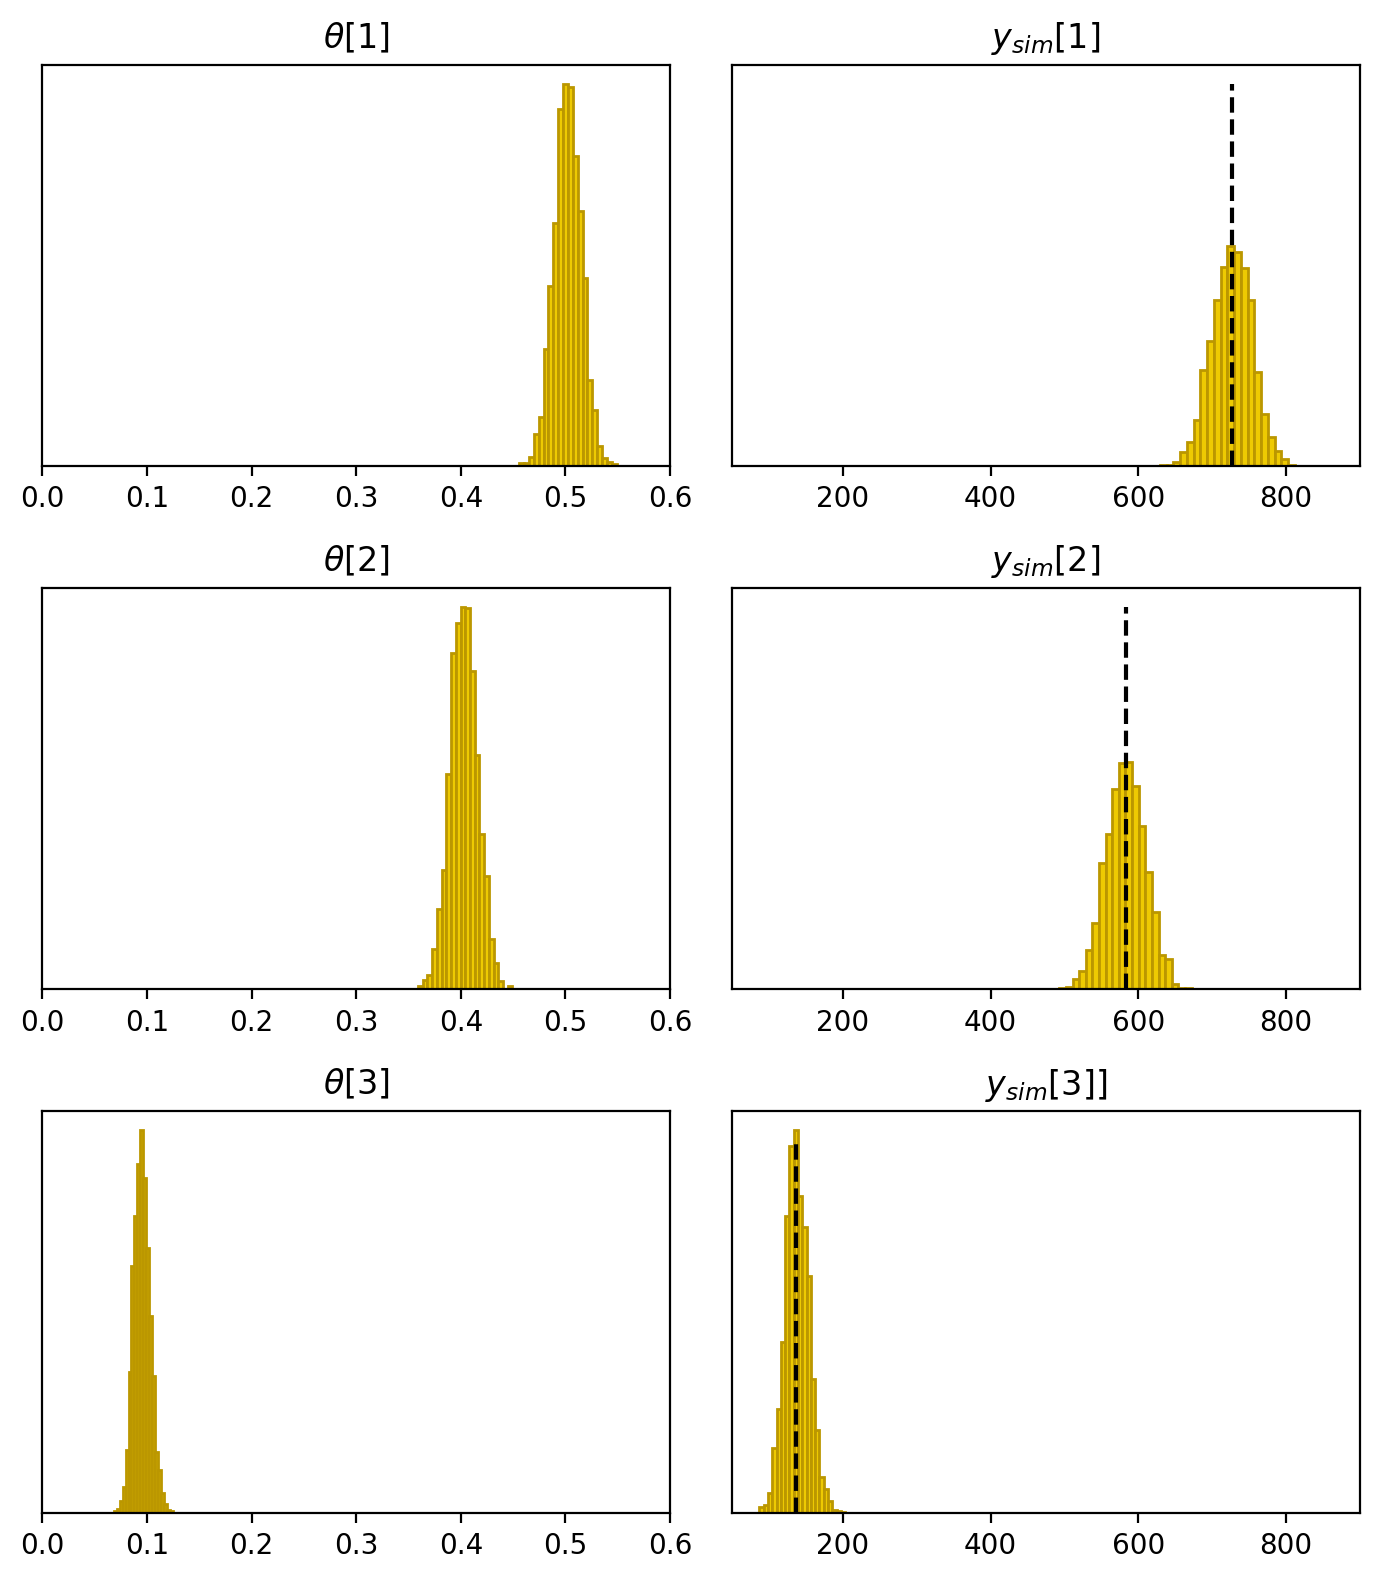

In [15]:
fig, axes = plt.subplots(3, 2, figsize=(7, 8), squeeze=False)
axes_flat=axes.flatten()
tvs=iter(data)
for k in range(len(axes_flat)):
    ax = axes_flat[k]
    ax.hist(y_sim[:,k],bins=20,color=dark,edgecolor=dark_highlight,density=True)
    ax.set_title(titles[k])
    if (k % 2) == 1:
        tv = next(tvs)
        ax.plot([tv,tv],[0,0.025],linestyle='--',color='black')
        ax.set_xlim([50,900])
    else:
        ax.set_xlim([0,0.6])
        
    ax.set_yticks([])
#    ax.set_xticks([0,tv,50])
#    ax.set_xticklabels([0,tv,50])
    

fig.tight_layout()

plt.show()

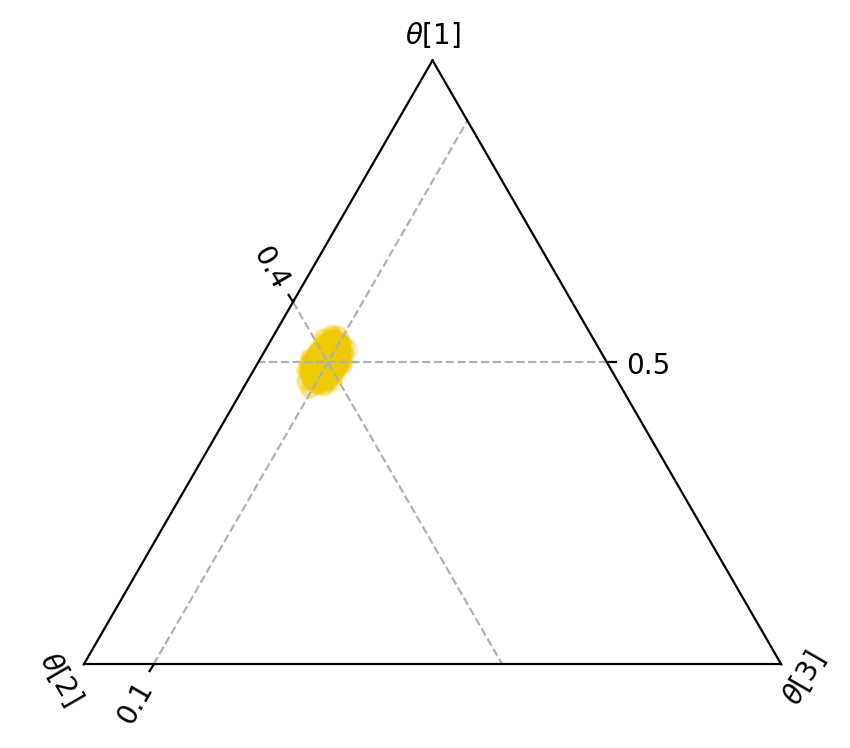

In [16]:
fig, ax_tr = plt.subplots(1, 1, figsize=(7, 4),subplot_kw={'projection':'ternary'})
ax_tr.set_tlabel(r'$\theta[1]$')
ax_tr.set_llabel(r'$\theta[2]$')
ax_tr.set_rlabel(r'$\theta[3]$')
ax_tr.taxis.set_ticks([0.5])
ax_tr.laxis.set_ticks([0.4])
ax_tr.raxis.set_ticks([0.1])
ax_tr.scatter(y_sim[:,0], y_sim[:,2], y_sim[:,4],alpha=0.2,color=dark)
ax_tr.grid(linestyle='--')

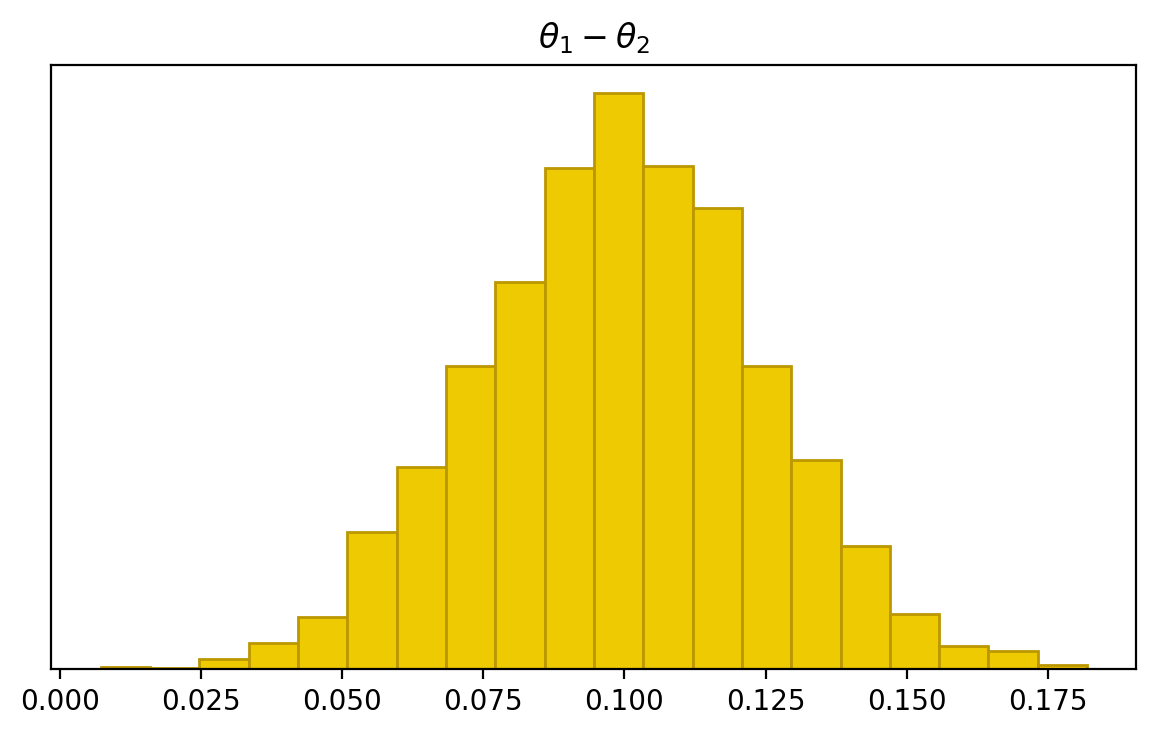

In [17]:
advantage=fit.extract()['advantage']
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes.hist(advantage,bins=20,color=dark,edgecolor=dark_highlight,density=True)
axes.set_title(r'$\theta_1-\theta_2$')
axes.set_yticks([])
plt.show()

## Probability of Dukakis winning.

In [18]:
print(np.sum([advantage<0])/4000)

0.0


In [19]:
az.summary(fit,stat_funcs=func_dict,extend=False,var_names=['advantage'])

,median,5%,95%
advantage,0.1,0.058,0.14
